# Notebook de preparación del dataset para YOLO

## Cajas delimitadoras

In [1]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = os.getcwd()+"/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print(" El directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print(" Contenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = current_directory+"/masks"
data_directory = current_directory+"/data"

os.chdir(route+"/../yolo_segmentation")
save_directory = os.getcwd()


Vamos a cambiar el directorio de trabajo
 El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation
 Contenido del directorio actual:
	 train_models
	 data
	 create_dataset.ipynb
	 data_files_1c.csv
	 images
	 image_analysis.ipynb
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb
	 dataset_info.csv
	 data_files_1c_train.csv
	 historico_notebooks
	 data_files_1c_test.csv
	 segmentation_no_supervisada_pytorch_clean.ipynb
	 segmentation_supervisada_pytorch copy.ipynb
	 segmentation_supervisada_pytorch.ipynb
	 cesga
	 segmentation_supervisada_pytorch copy 2.ipynb
	 segmentation_supervisada_pytorch copy 3.ipynb
	 data_files_1c_train_da.csv


In [47]:
import os
from skimage import measure, io
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists(save_directory+"/labels/train"):
    os.makedirs(save_directory+"/labels/train")

for mask_name in os.listdir(masks_directory):
    if mask_name.endswith('.png'):
        mask_path = os.path.join(masks_directory, mask_name)
        mask = plt.imread(mask_path, format='grayscale')
        if mask.ndim > 2:
            mask = mask[..., 0]

        mask = (mask.round() > 0).astype(np.uint8)  # Asegurarse de que la máscara sea binaria
        
        labeled_mask = measure.label(mask)
        regions = measure.regionprops(labeled_mask)

        height, width = mask.shape
        label_path = os.path.join(save_directory+"/labels", mask_name.replace('.png', '.txt'))
        with open(label_path, 'w') as f:
            for region in regions:
                minr, minc, maxr, maxc = region.bbox
                x_center = (minc + maxc) / 2 / width
                y_center = (minr + maxr) / 2 / height
                w_norm = (maxc - minc) / width
                h_norm = (maxr - minr) / height
                f.write(f"0 {x_center} {y_center} {w_norm} {h_norm}\n")

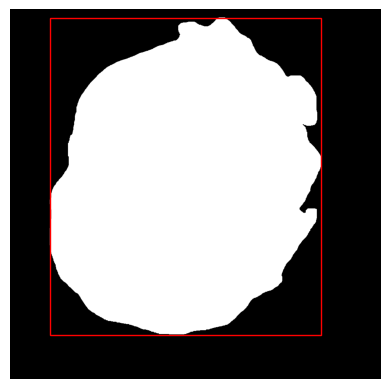

In [189]:
# Rutas de la máscara y el archivo de etiquetas
mask_name = 'YM16_contour.png'
mask_path = os.path.join(masks_directory, mask_name)
label_path = os.path.join(save_directory+"/labels/train", mask_name.replace('.png', '.txt'))

# Cargar la máscara
mask = io.imread(mask_path, as_gray=True)
mask = (mask.round() > 0).astype(np.uint8)  # Asegurarse de que la máscara sea binaria

# Leer el archivo de etiquetas
with open(label_path, 'r') as f:
    lines = f.readlines()

# Dibujar la máscara y el rectángulo
fig, ax = plt.subplots()
ax.imshow(mask, cmap='gray')

height, width = mask.shape
for line in lines:
    class_id, x_center, y_center, w_norm, h_norm = map(float, line.split())
    x_center *= width
    y_center *= height
    w = w_norm * width
    h = h_norm * height
    x_min = x_center - w / 2
    y_min = y_center - h / 2
    rect = plt.Rectangle((x_min, y_min), w, h, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()

## Convertir fits a JPG

Lo realizamos para el conjunto de entrenamiento

In [178]:
import numpy as np
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm, TypicalImageNorm
from pnebulae_torch.preprocess import ApplyIntensityTransformation, CutValues
from skimage import exposure
from torchvision import transforms
import torch
import pandas as pd

transform_x = transforms.Compose([
                    CutValues(factor = 2),
                    TypicalImageNorm(factor = 1, substract=0)
                    
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor()
                    ])

df_train = pd.read_csv(route+"/data_files_1c_train.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))



In [179]:
from PIL import Image

if not os.path.exists(save_directory+"/data/train"):
    os.makedirs(save_directory+"/data/train")

for i in range(len(dataset_train)):
    
    file_name = df_train.iloc[i]['mask']#.replace('.png', '.jpg')
    file_path = os.path.join(save_directory+"/data/train", file_name)
    
    image = Image.fromarray((dataset_train[i][0]*255).round().astype(np.uint8))
    image.save(file_path)

In [182]:
import os
from skimage import measure, io
import numpy as np

if not os.path.exists(save_directory + "/labels/train"):
    os.makedirs(save_directory + "/labels/train")

for mask_name in os.listdir(masks_directory):
    if mask_name.endswith('.png'):
        mask_path = os.path.join(masks_directory, mask_name)
        mask = plt.imread(mask_path, format='grayscale')
        
        if mask.ndim > 2:
            mask = mask[..., 0]

        mask = (mask.round() > 0).astype(np.uint8)  # Asegurarse de que la máscara sea binaria
        
        labeled_mask = measure.label(mask)
        regions = measure.regionprops(labeled_mask)

        height, width = mask.shape
        label_path = os.path.join(save_directory + "/labels/train", mask_name.replace('.png', '.txt'))
        with open(label_path, 'w') as f:
            for region in regions:
                coords = region.coords.astype(np.float32)
                coords = coords[:, [1, 0]]  # Intercambiar columnas para tener (x, y)
                coords[:, 0] = coords[:, 0] / width  # Normalizar coordenadas x
                coords[:, 1] = coords[:, 1] / height  # Normalizar coordenadas y
                coords = coords.flatten()
                coords_str = ' '.join(map(str, coords))
                f.write(f"0 {coords_str}\n")

Y también para el de test

In [183]:
import numpy as np
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm, TypicalImageNorm
from pnebulae_torch.preprocess import ApplyIntensityTransformation, CutValues
from skimage import exposure
from torchvision import transforms
import torch
import pandas as pd

transform_x = transforms.Compose([
                    CutValues(factor = 2),
                    TypicalImageNorm(factor = 1, substract=0)
                    
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor()
                    ])

df_test = pd.read_csv(route+"/data_files_1c_test.csv")
dataset_test = NebulaeDataset(data_directory, masks_directory, df_test, transform = (transform_x, transform_y))

In [177]:
from PIL import Image

if not os.path.exists(save_directory+"/data/test"):
    os.makedirs(save_directory+"/data/test")

for i in range(len(dataset_test)):
    
    file_name = df_test.iloc[i]['mask']#.replace('.png', '.jpg')
    file_path = os.path.join(save_directory+"/data/test", file_name)
    
    image = Image.fromarray((dataset_test[i][0]*255).round().astype(np.uint8))
    image.save(file_path)

In [186]:
import os
from skimage import measure, io
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists(save_directory+"/labels/test"):
    os.makedirs(save_directory+"/labels/test")
    
for i in range(len(dataset_test)):
    mask_name = df_test.iloc[i]['mask']
    if mask_name.endswith('.png'):
        mask_path = os.path.join(masks_directory, mask_name)
        mask = plt.imread(mask_path, format='grayscale')
        if mask.ndim > 2:
            mask = mask[..., 0]

        mask = (mask.round() > 0).astype(np.uint8)  # Asegurarse de que la máscara sea binaria
        
        labeled_mask = measure.label(mask)
        regions = measure.regionprops(labeled_mask)

        height, width = mask.shape
        label_path = os.path.join(save_directory+"/labels/test", mask_name.replace('.png', '.txt'))
        with open(label_path, 'w') as f:
            for region in regions:
                minr, minc, maxr, maxc = region.bbox
                x_center = (minc + maxc) / 2 / width
                y_center = (minr + maxr) / 2 / height
                w_norm = (maxc - minc) / width
                h_norm = (maxr - minr) / height
                f.write(f"0 {x_center} {y_center} {w_norm} {h_norm}\n")

Copiamos los .png referentes a la máscara en sus carpetas correspondientes en labels

In [101]:
import shutil

if not os.path.exists(save_directory+"/labels/train"):
    os.makedirs(save_directory+"/labels/train")

source_path = masks_directory
destination_path = save_directory+"/labels/train"

for i in range(len(dataset_train)):
    file_name = df_train.iloc[i]['mask']
    shutil.copy(source_path+"/"+file_name, destination_path+"/"+file_name)

In [102]:
if not os.path.exists(save_directory+"/labels/test"):
    os.makedirs(save_directory+"/labels/test")

source_path = masks_directory
destination_path = save_directory+"/labels/test"

for i in range(len(dataset_test)):
    file_name = df_test.iloc[i]['mask']
    shutil.copy(source_path+"/"+file_name, destination_path+"/"+file_name)

In [104]:
destination_path = save_directory+"/labels/train"

# Contar la cantidad de archivos
file_count = len([name for name in os.listdir(destination_path) if os.path.isfile(os.path.join(destination_path, name))])

print(f"Cantidad de archivos en la carpeta: {file_count}")

Cantidad de archivos en la carpeta: 192


In [174]:
from PIL import Image
import numpy as np

# Ruta de la imagen de máscara
mask_path = save_directory+"/segment/labels/train_converted/Pe1_14_contour.png"

# Cargar la imagen con PIL
image = Image.open(mask_path)

# Convertir la imagen a un array de numpy
image_array = np.array(image)

# Ver los valores del array de numpy
print(image_array.shape)


(246, 246)


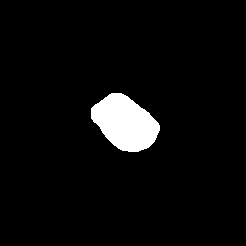

In [175]:
image.show()

In [147]:
mask_path = os.path.join(save_directory, "segment/labels/val")

# Crear directorio para guardar las imágenes convertidas
converted_path = os.path.join(save_directory, "segment/labels/val_converted")
if not os.path.exists(converted_path):
    os.makedirs(converted_path)

for mask_name in os.listdir(mask_path):
    if mask_name.endswith('.png'):
        mask_full_path = os.path.join(mask_path, mask_name)
        
        # Cargar la imagen
        mask = Image.open(mask_full_path)
        
        # Convertir a escala de grises
        mask_gray = mask.convert('L')
        
        # Guardar la imagen convertida
        mask_gray.save(os.path.join(converted_path, mask_name))

print("Conversión completada.")

Conversión completada.


In [173]:
import os
from PIL import Image
import numpy as np

mask_path = os.path.join(save_directory, "segment/labels/val")

# Crear directorio para guardar las imágenes convertidas
converted_path = os.path.join(save_directory, "segment/labels/val_converted")
if not os.path.exists(converted_path):
    os.makedirs(converted_path)

for mask_name in os.listdir(mask_path):
    if mask_name.endswith('.png'):
        mask_full_path = os.path.join(mask_path, mask_name)
        
        # Cargar la imagen
        mask = Image.open(mask_full_path)
        
        # Convertir la imagen a un array de numpy
        mask_array = np.array(mask)
        
        # Ajustar los píxeles con valor 1 a 0
        mask_array[mask_array == 1] = 0
        
        # Convertir el array de numpy de nuevo a imagen
        mask_gray_corrected = Image.fromarray(mask_array)
        
        # Guardar la imagen convertida
        mask_gray_corrected.save(os.path.join(converted_path, mask_name))

print("Conversión completada.")

Conversión completada.
